In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Network Visualization (TensorFlow)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

In [2]:
import tensorflow as tf
import vgg
slim = tf.contrib.slim
import matplotlib.pyplot as plt
from data_utils import load_imagenet_val
import numpy as np
from image_utils import preprocess_image, deprocess_image, VGG_MEAN

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

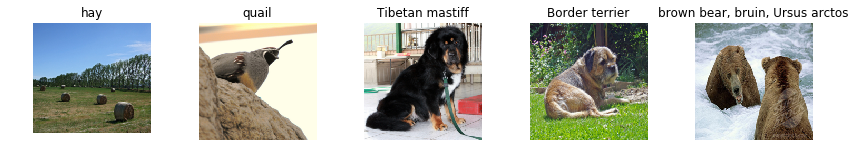

In [3]:
x_raw, y, class_names = load_imagenet_val(num=5)
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_raw[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Preprocess images
The input to the pretrained VGG-16 model is expected to be subtracted the pixelwise mean.

In [4]:
x = np.array([preprocess_image(img) for img in x_raw])

# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use VGG-16.

The TensorFlow has a lot of pre-trained models available in https://github.com/tensorflow/models/tree/master/research/slim.

We have include the tf.slim VGG model in Github HW3 folder and you can see: `vgg.py` for the model architecture. We strongly recommend you check it out before running the following cells.

To use VGG-16, you will need to first **download the weights** by downloading `vgg_16_2016_08_28.tar.gz`. Once you unzip it, you will have the `vgg_16.ckpt` that includes all the learned parameters.

Once you've downloaded the model and weights, you can run the following cell to load the model in TensorFlow.

In [5]:
tf.reset_default_graph()
#number of classes for ImageNet
NUM_CLASSES = 1000

#Define input data as X
X = tf.placeholder(dtype=tf.float32,shape=[None,224,224,3])
#Define target label as Y
Y = tf.placeholder(dtype=tf.int32,shape=[None])

#initialize vgg-16 model
#scores: the output of last layer
#end_points: include all layers outputs
scores, end_points = vgg.vgg_16(inputs=X,num_classes=1000,is_training=False,spatial_squeeze=True,dropout_keep_prob=1.)

#the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(Y, NUM_CLASSES), logits=scores))

#get the variables (weights, biases) to restore
variables_to_restore = slim.get_variables_to_restore()

#define the saver
saver = tf.train.Saver(variables_to_restore)

Instructions for updating:
Colocations handled automatically by placer.


## Graph in Tensorboard
You can visaulize the architecture of VGG-16 by running the following cell.

In [6]:
from tensorflow_graph_in_jupyter import show_graph
show_graph(tf.get_default_graph())

## Restore the variables

In [7]:
#create the session
sess = get_session()
#restore the variables
saver.restore(sess,"vgg_16.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from vgg_16.ckpt


# Part a: Visualize feature maps
This is a warm up step that helps you to understand the architecture of VGG-16 and also explore the feature maps in different layers of CNN. Given the images `x` we defined above, using the pretrained VGG-16 model to get all their feature maps. use `plt.imshow()` to plot out the first and last feature map of `conv1/conv1_1` and `conv1/conv1_2` for all five images.

Hint:the `end_points` is an ordered-dictionary.

Images are in order so the first layer is the first feature map of conv1/conv1_1 etc


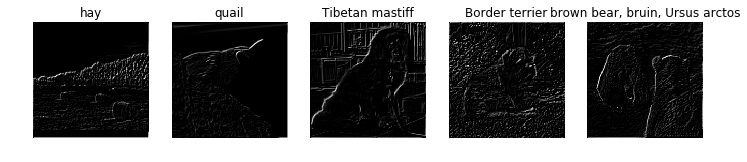

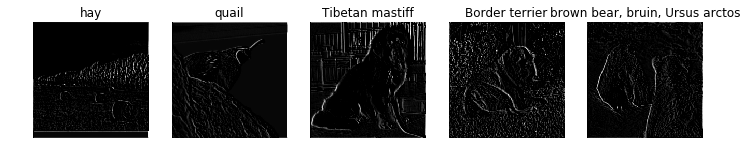

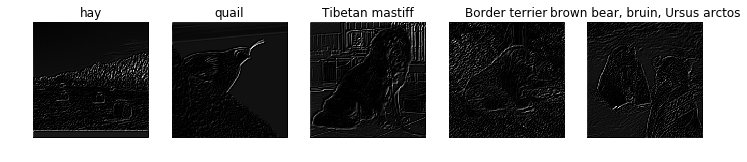

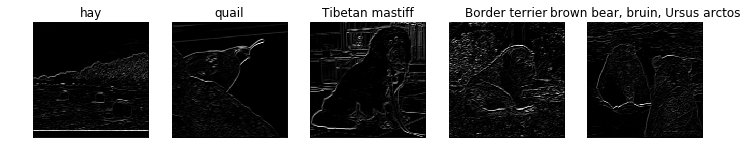

In [8]:
#init = tf.global_variables_initializer()

####### START YOUR CODE ######
#with tf.Session() as sess:
    #sess.run(init)
    
#get out the end points matrices
scores_0, end_points_0 = sess.run((scores, end_points), feed_dict={X:x, Y:y})

#print(scores_0.shape)

#get the first layer
conv1_layer = end_points_0.get('vgg_16/conv1/conv1_1')

#print(conv1_layer.shape)
print("Images are in order so the first layer is the first feature map of conv1/conv1_1 etc")
#print the images, layer 0
plt.figure(figsize=(12, 6))
for i in range(5):
    #extract the image
    conv_img = conv1_layer[i]
    conv_img = conv_img[:,:,0]

    #plot the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(conv_img)
    #plt.show()
    plt.title(class_names[y[i]])
    plt.axis('off')

#print the image layer 63
plt.figure(figsize=(12, 6))
for i in range(5):
    #extract the image
    conv_img = conv1_layer[i]
    conv_img = conv_img[:,:,63]

    #plot the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(conv_img)
    #plt.show()
    plt.title(class_names[y[i]])
    plt.axis('off')

#get the second layer
conv1_layer = end_points_0.get('vgg_16/conv1/conv1_2')

#print(conv1_layer.shape)

#print the images, layer 0
plt.figure(figsize=(12, 6))
for i in range(5):
    #extract the image
    conv_img = conv1_layer[i]
    conv_img = conv_img[:,:,0]

    #plot the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(conv_img)
    #plt.show()
    plt.title(class_names[y[i]])
    plt.axis('off')

#print the image layer 63
plt.figure(figsize=(12, 6))
for i in range(5):
    #extract the image
    conv_img = conv1_layer[i]
    conv_img = conv_img[:,:,63]

    #plot the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(conv_img)
    #plt.show()
    plt.title(class_names[y[i]])
    plt.axis('off')
###### END OF YOUR CODE ######

# Part b: Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [1].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

You will need to use the `scores` Tensor containing the scores for each input, and will need to feed in values for the `image (X)` and `labels (Y)` placeholder when evaluating the gradient. 

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [9]:
def compute_saliency_maps(x, y, X, Y, scores, loss):
    """
    Compute a class saliency map using the model for images x and labels y.

    Input:
    - x: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for x, numpy of shape (N,)
    - X: images placeholder
    - Y: labels placeholder
    - scores: the scores for input image, an (N,1000) shape
    - loss: the loss function
    
    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """
    saliency = []
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    #
    # Note: this is equivalent to scores[np.arange(N), y] we used in NumPy
    # for computing vectorized losses.
    correct_scores = tf.gather_nd(scores,
                                  tf.stack((tf.range(x.shape[0]), Y), axis=1))
    ###############################################################################
    # TODO: Produce the saliency maps over a batch of images.                     #
    #                                                                             #
    # 1) Use tf.gradients to compute the gradient of the loss with respect        #
    #    to the image (accessible via model.image).                               #
    # 2) Compute the actual value of the gradient by a call to sess.run().        #
    #    You will need to feed in values for the placeholders X and Y.            #
    # 3) Finally, process the returned gradient to compute the saliency map.      #
    ###############################################################################
    #get the gradient
    grads = tf.gradients(ys = correct_scores, xs = X)
    actual_grads = sess.run(grads, feed_dict={X:x, Y:y})

    #loop over the images to create the saliency maps
    abs_grad = np.abs(actual_grads)[0]
    #print(abs_grad.shape)
    N = 5
    for i in range(N):
        #get each image
        local_grad = abs_grad[i]
        h, w, _ = local_grad.shape
        local_grad_1 = np.zeros([h,w])
        
        #get max
        for i in range(h):
            for j in range(w):
                max_val = np.max(local_grad[i][j])
                local_grad_1[i][j] = max_val
        
        saliency.append(local_grad_1)

    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

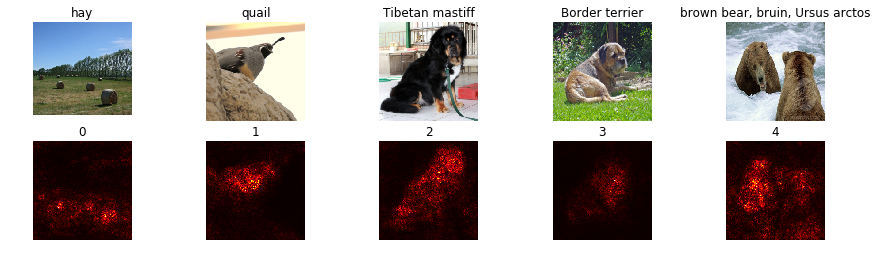

In [10]:
def show_saliency_maps(x, y, X, Y, mask, scores, loss):
    mask = np.asarray(mask)
    xm = x[mask]
    ym = y[mask]

    saliency = compute_saliency_maps(xm,ym,X,Y,scores,loss)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(15, 4)
    plt.show()

mask = np.arange(5)
show_saliency_maps(x, y, X,Y, mask,scores,loss)

# Part c: Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [2]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[2] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [17]:
def make_fooling_image(x, target_y,X,Y,scores):
    """
    Generate a fooling image that is close to x, but that the model classifies
    as target_y.

    Inputs:
    - x: Input image, a numpy array of shape (1, 224, 224, 3)
    - target_y: An integer in the range [0, 1000)
    - X: input image placeholder
    - Y: target label placeholder
    - scores: the score for input image

    Returns:
    - x_fooling: An image that is close to x, but that is classifed as target_y
    by the model.
    """
    
    # Make a copy of the input that we will modify
    x_fooling = x.copy()
    x_max_img = x.copy() + 0.1
    x_min_img = x.copy() - 0.1
    
    # Step size for the update, feel free to change
    learning_rate = 2.0
    
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. Use gradient *ascent* on the target class score, using #
    # the scores Tensor to get the class scores for the image placeholder(X).    #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * gradient / ||gradient||_2                           #
    #                                                                            #
    # You should write a training loop, where in each iteration, you make an     #
    # update to the input image x_fooling (don't modify x). The loop should      #
    # stop when the predicted class for the input is the same as target_y.       #
    #                                                                            #
    # HINT: It's good practice to define your TensorFlow graph operations        #
    # outside the loop, and then just make sess.run() calls in each iteration.   #
    #                                                                            #
    # HINT 2: For most examples, you should be able to generate a fooling image  #
    # in fewer than 400 iterations of gradient ascent. You can print your        #
    # progress over iterations to check your algorithm.                          #
    ##############################################################################
    #get the gradient norm
    grads = tf.gradients(ys = scores[:,target_y], xs = X)[0]
    norm_grads = (learning_rate * grads) / tf.norm(grads)
    
    for i in range(500):
        #get each image
        actual_grads = sess.run(norm_grads, feed_dict={X:x_fooling})#[target_y]
        
        #get dx and apply it
        dX = actual_grads
        
        x_fooling += dX
         
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return x_fooling

Run the following to generate a fooling image. You should ideally see at first glance no major difference between the original and fooling images, and the network should now make an incorrect prediction on the fooling one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and fooling images. Feel free to change the `idx` variable to explore other images.

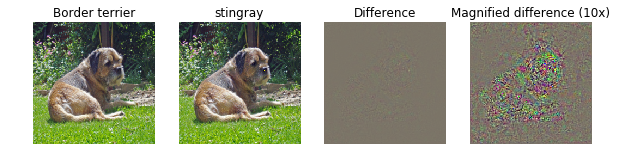

In [18]:
idx = 3
xi = x[idx][None]
target_y = 6
x_fooling = make_fooling_image(xi, target_y, X,Y, scores)

# Make sure that X_fooling is classified as y_target
scores_ = sess.run(scores, {X: x_fooling})
assert scores_[0].argmax() == target_y, 'The network is not fooled!'

# Show original image, fooling image, and difference
orig_img = deprocess_image(xi[0])
fool_img = deprocess_image(x_fooling[0])
# Rescale 
plt.subplot(1, 4, 1)
plt.imshow(orig_img)
plt.axis('off')
plt.title(class_names[y[idx]])
plt.subplot(1, 4, 2)
plt.imshow(fool_img)
plt.title(class_names[target_y])
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title('Difference')
plt.imshow(deprocess_image((xi-x_fooling)[0]))
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title('Magnified difference (10x)')
plt.imshow(deprocess_image(10 * (xi-x_fooling)[0]))
plt.axis('off')
plt.gcf().set_size_inches(10, 8)

# Part d: Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [1]; [2] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = {\arg\max}_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [2] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [19]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(x, sigma=1):
    x = gaussian_filter1d(x, sigma, axis=1)
    x = gaussian_filter1d(x, sigma, axis=2)
    return x

In [20]:
def create_class_visualization(target_y, X,Y,scores, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - X: image placeholder
    - Y: target label placeholder
    - scores: the score for your image
    
    Keyword arguments:(feel free to change any values that fit with you)
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-6)
    learning_rate = kwargs.pop('learning_rate', 1500)
    num_iterations = kwargs.pop('num_iterations', 500)
    blur_every = kwargs.pop('blur_every', 100)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 100)
    
    # We use a single image of random noise as a starting point
    x = 255 * np.random.rand(224, 224, 3)
    x = preprocess_image(x)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use tf.gradients to compute                                          #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    grads = tf.gradients(ys = scores[:,target_y], xs = X)[0]
    
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        x = np.roll(np.roll(x, ox, 1), oy, 2)
        
        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        actual_grads = sess.run(grads, feed_dict={X:x, Y: [target_y]})
        
        dX = learning_rate * actual_grads
        
        x += dX
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        x = np.roll(np.roll(x, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        x = np.clip(x, 0.-VGG_MEAN, 255 - VGG_MEAN)
        
        if t % blur_every == 0:
            x = blur_image(x, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess_image(x[0]))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
    return x

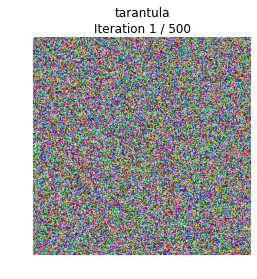

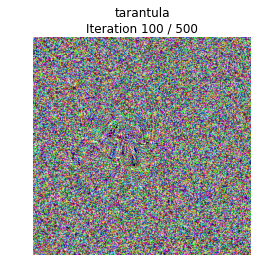

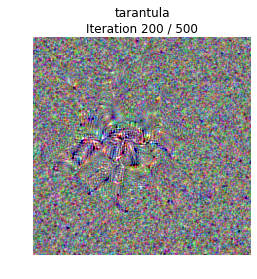

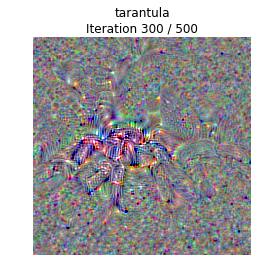

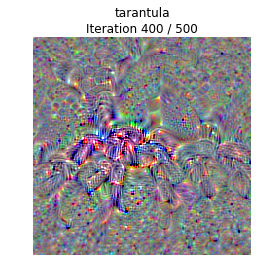

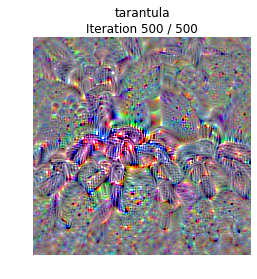

In [21]:
target_y = 76 # Tarantula
out = create_class_visualization(target_y, X,Y, scores)

scores_ = sess.run(scores, {X: out})
assert scores_[0].argmax() == target_y, 'The network is not fooled!'

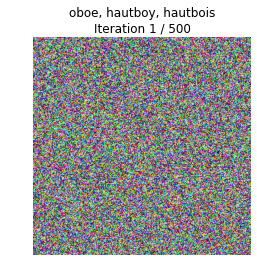

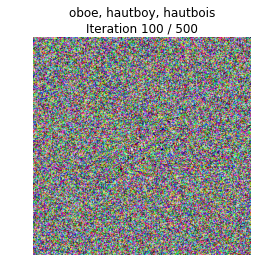

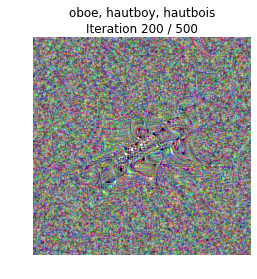

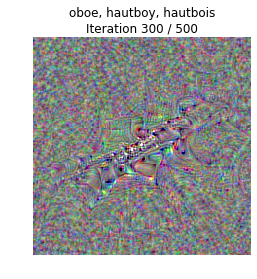

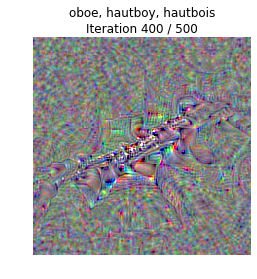

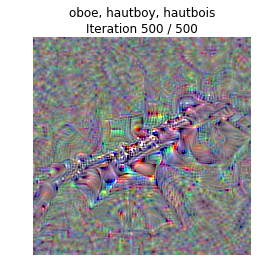

In [22]:
target_y = 683 # Oboe
out = create_class_visualization(target_y, X,Y, scores)

scores_ = sess.run(scores, {X: out})
assert scores_[0].argmax() == target_y, 'The network is not fooled!'

In [23]:
#try any class, you may need to increase the number of interations to see the class pattern
# target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass